In [5]:
# yunzhe and beatrice generated IsoQuant results from the WTC11 LRGASP data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
iq_cerberus_h5 = od+expand(config['lr']['isoquant']['cerberus']['ca_annot'], species='human', obs_col='sample')[0]


iq_gtf = od+expand(config['lr']['isoquant']['gtf'], species='human')[0]
iq_ics = od+expand(config['lr']['isoquant']['cerberus']['ics'], species='human')[0]
iq_ab = od+expand(config['lr']['isoquant']['novel_ab'], species='human')[0]
iq_filt_ab = od+expand(config['lr']['isoquant']['cerberus']['ab'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

## First figure out which transcripts are expressed using the same criteria as we do for the TALON+LAPA data

* Does that actually make sense tho? Probably not...

In [4]:
def get_iq_df_tpm(df, feat):
    dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
    df = df[dataset_cols+['annot_transcript_id']]
    if feat != 'triplet':
        df = add_feat(df, col='annot_transcript_id', kind=feat)
        df.drop('annot_transcript_id', inplace=True, axis=1)
        gb_col = feat
    else:
        gb_col = 'annot_transcript_id'
    df = df.groupby(gb_col).sum().reset_index()
    
    return df


In [5]:
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'triplet')

tl_df = pd.read_csv(filt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None,
                         sample=['wtc11'])

tl_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='annot_transcript_id', suffixes=('_iq', ''))
df['iq_det'] = ~df.wtc11_1_1_iq.isna()
df['tl_det'] = ~df.wtc11_1_1.isna()
df = df[['annot_transcript_id', 'iq_det', 'tl_det']]
df.groupby(['iq_det', 'tl_det']).count()
df.head()


Calculating iso TPM values
Subsetting for ['wtc11'] samples
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 64107
Number of isos reported: 64107


,annot_transcript_id,iq_det,tl_det
0,"ENSG00000000003[1,1,5]",True,True
1,"ENSG00000000003[2,2,1]",True,False
2,"ENSG00000000005[2,3,1]",True,False
3,"ENSG00000000419[1,1,1]",True,True
4,"ENSG00000000419[1,16,1]",True,False


In [ ]:
min_tpm = 0
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'ic')

tl_df = pd.read_csv(filt_ab, sep='\t')
# tl_df = pd.read_csv(unfilt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=None,
                         sample=['wtc11'])

tl_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_iq', ''))
df.fillna(0, inplace=True)
# df['iq_det'] = ~df.wtc11_1_1_iq.isna()
# df['tl_det'] = ~df.wtc11_1_1.isna()
iq_cols = ['wtc11_1_1_iq', 'wtc11_1_2_iq', 'wtc11_1_3_iq']
df['iq_det'] = df[iq_cols].sum(axis=1) != 0
df['iq_avg_tpm'] = df[iq_cols].mean(axis=1)
tl_cols = ['wtc11_1_1', 'wtc11_1_2', 'wtc11_1_3']
df['tl_det'] = df[tl_cols].sum(axis=1) != 0
df['tl_avg_tpm'] = df[tl_cols].mean(axis=1)
df['det_cat'] = df['iq_det'].astype(str)+'_'+df['tl_det'].astype(str)
df = df.loc[df.det_cat != 'False_False']

df['tl_log2_avg_tpm'] = np.log2(df.tl_avg_tpm+1)
df['iq_log2_avg_tpm'] = np.log2(df.iq_avg_tpm+1)

print(df.loc[df.ic.str.contains('ENSG00000000003')])


temp = df[['ic', 'iq_det', 'tl_det']]
temp = temp.groupby(['iq_det', 'tl_det']).count().reset_index()
print(temp)


Calculating ic TPM values
Subsetting for ['wtc11'] samples
Number of ics reported: 145392


In [ ]:
df.loc[df.ic.str.contains('ENSG00000000003')]
sns.jointplot(df, y='iq_log2_avg_tpm', x='tl_log2_avg_tpm', hue='det_cat')

In [16]:
# temp2 = df.loc[(df.det_cat=='True_False')|(df.det_cat=='False_True')]
# temp2['det_log2_avg_tpm'] = temp2[['iq_log2_avg_tpm', 'tl_log2_avg_tpm']].max(axis=1)
# temp2.head()
# sns.catplot(temp2, y='det_log2_avg_tpm', x='det_cat', kind='violin')

In [9]:
# df.loc[(df.iq_det==True)&(df.tl_det==False)].head()

In [19]:
df.loc[(df.det_cat=='False_True')&(df.tl_log2_avg_tpm<2)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
37876,ENSG00000000003_11,0.0,0.0,0.0,1.132073,0.000000,1.372698,False,0.0,True,0.834924,False_True,0.875720,0.0
37877,ENSG00000000003_12,0.0,0.0,0.0,0.000000,1.926363,0.000000,False,0.0,True,0.642121,False_True,0.715560,0.0
37879,ENSG00000000003_6,0.0,0.0,0.0,0.566036,0.963181,0.457566,False,0.0,True,0.662261,False_True,0.733147,0.0
37881,ENSG00000000003_8,0.0,0.0,0.0,0.566036,0.000000,0.000000,False,0.0,True,0.188679,False_True,0.249359,0.0
37882,ENSG00000000003_9,0.0,0.0,0.0,2.264145,0.963181,2.287830,False,0.0,True,1.838386,False_True,1.505071,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154661,TALONG000186746_1,0.0,0.0,0.0,0.566036,0.000000,0.457566,False,0.0,True,0.341201,False_True,0.423525,0.0
154662,TALONG000187635_1,0.0,0.0,0.0,0.000000,2.889544,2.287830,False,0.0,True,1.725791,False_True,1.446675,0.0
154663,TALONG000189031_1,0.0,0.0,0.0,1.698109,0.000000,0.000000,False,0.0,True,0.566036,False_True,0.647118,0.0
154667,TALONG000195728_1,0.0,0.0,0.0,0.000000,1.926363,2.745396,False,0.0,True,1.557253,False_True,1.354595,0.0


In [18]:
df.loc[(df.det_cat=='True_False')&(df.iq_log2_avg_tpm<2)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
1,ENSG00000000003_2,0.614607,2.291045,0.000000,0.0,0.0,0.0,True,0.968551,False,0.0,True_False,0.0,0.977134
8,ENSG00000000457_10,0.181090,1.145523,0.768900,0.0,0.0,0.0,True,0.698504,False,0.0,True_False,0.0,0.764265
10,ENSG00000000457_9,0.729846,0.000000,0.768900,0.0,0.0,0.0,True,0.499582,False,0.0,True_False,0.0,0.584560
11,ENSG00000000460_1,0.773746,2.291045,0.768900,0.0,0.0,0.0,True,1.277897,False,0.0,True_False,0.0,1.187703
14,ENSG00000000460_16,0.224990,2.291045,1.537799,0.0,0.0,0.0,True,1.351278,False,0.0,True_False,0.0,1.233445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37863,ENSG00000285825_4,1.646269,0.000000,0.768900,0.0,0.0,0.0,True,0.805056,False,0.0,True_False,0.0,0.852044
37866,ENSG00000285897_2,0.548756,0.000000,0.768900,0.0,0.0,0.0,True,0.439219,False,0.0,True_False,0.0,0.525286
37868,ENSG00000285942_2,0.548756,1.145523,0.768900,0.0,0.0,0.0,True,0.821060,False,0.0,True_False,0.0,0.864778
37872,ENSG00000285982_2,1.097513,0.572761,1.922249,0.0,0.0,0.0,True,1.197508,False,0.0,True_False,0.0,1.135868


In [15]:
df.loc[(df.det_cat=='False_True')&(df.tl_log2_avg_tpm>10)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
65867,ENSG00000115053_1,0.0,0.0,0.0,1278.110073,1031.567308,1240.003898,False,0.0,True,1183.227093,False_True,10.209730,0.0
77829,ENSG00000132341_1,0.0,0.0,0.0,934.526010,1392.760343,1225.819352,False,0.0,True,1184.368568,False_True,10.211120,0.0
93670,ENSG00000150753_1,0.0,0.0,0.0,953.771245,1096.100464,1021.287344,False,0.0,True,1023.719684,False_True,10.001014,0.0
104602,ENSG00000165280_1,0.0,0.0,0.0,1256.034655,883.237368,1077.567963,False,0.0,True,1072.279996,False_True,10.067811,0.0
118353,ENSG00000181163_1,0.0,0.0,0.0,1608.109263,2542.798967,2218.280037,False,0.0,True,2123.062756,False_True,11.052611,0.0
120311,ENSG00000184009_1,0.0,0.0,0.0,3027.728423,3186.204160,3061.574201,False,0.0,True,3091.835594,False_True,11.594714,0.0


In [10]:
df.loc[(df.det_cat=='True_False')&(df.iq_log2_avg_tpm>10)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
7199,ENSG00000105372_4,440.212345,3122.981088,1121.055571,0.0,0.0,0.0,True,1561.416335,False,0.0,True_False,0.0,10.609563
26941,ENSG00000172270_6,1601.205183,2256.301572,1703.781487,0.0,0.0,0.0,True,1853.762747,False,0.0,True_False,0.0,10.857019
27088,ENSG00000172757_2,1144.546610,1535.000333,1091.837388,0.0,0.0,0.0,True,1257.128110,False,0.0,True_False,0.0,10.297063
37605,ENSG00000277957_1,797.902710,2026.429544,1634.680483,0.0,0.0,0.0,True,1486.337579,False,0.0,True_False,0.0,10.538516


In [11]:
df.loc[(df.det_cat=='True_False')&(df.iq_log2_avg_tpm>10)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
7199,ENSG00000105372_4,440.212345,3122.981088,1121.055571,0.0,0.0,0.0,True,1561.416335,False,0.0,True_False,0.0,10.609563
26941,ENSG00000172270_6,1601.205183,2256.301572,1703.781487,0.0,0.0,0.0,True,1853.762747,False,0.0,True_False,0.0,10.857019
27088,ENSG00000172757_2,1144.546610,1535.000333,1091.837388,0.0,0.0,0.0,True,1257.128110,False,0.0,True_False,0.0,10.297063
37605,ENSG00000277957_1,797.902710,2026.429544,1634.680483,0.0,0.0,0.0,True,1486.337579,False,0.0,True_False,0.0,10.538516


In [13]:
g = 'ENSG00000172270'
df.loc[(df.ic.str.contains(g))]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
26937,ENSG00000172270_1,2.129175,5.349591,0.668943,0.000000,0.000000,0.000000,True,2.715903,False,0.000000,True_False,0.000000,1.893713
26938,ENSG00000172270_10,1.218239,4.593546,1.437842,0.000000,0.000000,0.000000,True,2.416542,False,0.000000,True_False,0.000000,1.772537
26939,ENSG00000172270_2,8.714251,8.786159,6.820139,0.000000,0.000000,0.000000,True,8.106850,False,0.000000,True_False,0.000000,3.186952
26940,ENSG00000172270_34,1615.785639,2280.208629,1710.893808,1079.997351,1661.487961,1210.719674,True,1868.962692,True,1317.401662,True_True,10.364574,10.868794
26941,ENSG00000172270_6,1601.205183,2256.301572,1703.781487,0.000000,0.000000,0.000000,True,1853.762747,False,0.000000,True_False,0.000000,10.857019
112351,ENSG00000172270_28,0.000000,0.000000,0.000000,3.962254,3.852726,5.490792,False,0.000000,True,4.435257,False_True,2.442348,0.000000
112352,ENSG00000172270_29,0.000000,0.000000,0.000000,3.396218,0.000000,0.915132,False,0.000000,True,1.437117,False_True,1.285175,0.000000
112353,ENSG00000172270_30,0.000000,0.000000,0.000000,0.000000,0.963181,0.000000,False,0.000000,True,0.321060,False_True,0.401697,0.000000
112354,ENSG00000172270_31,0.000000,0.000000,0.000000,1.132073,0.963181,0.000000,False,0.000000,True,0.698418,False_True,0.764192,0.000000
112356,ENSG00000172270_33,0.000000,0.000000,0.000000,78.113016,92.465417,88.767807,False,0.000000,True,86.448747,False_True,6.450366,0.000000


In [12]:
g = 'ENSG00000277957'
g2 = 'ENSG00000161960'

df.loc[(df.ic.str.contains(g))|(df.ic.str.contains(g2))]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
22432,ENSG00000161960_1,1784.780645,1140.940546,1046.472313,1749.618350,2310.672243,2000.936180,True,1324.064501,True,2020.408924,True_True,10.981145,10.371847
22433,ENSG00000161960_2,1.865772,1.145523,6.151197,0.000000,0.000000,0.000000,True,3.054164,False,0.000000,True_False,0.000000,2.019404
22434,ENSG00000161960_3,1.865772,0.000000,2.306699,5.094327,1.926363,2.745396,True,1.390824,True,3.255362,True_True,2.089282,1.257508
37605,ENSG00000277957_1,797.902710,2026.429544,1634.680483,0.000000,0.000000,0.000000,True,1486.337579,False,0.000000,True_False,0.000000,10.538516
100486,ENSG00000161960_32,0.000000,0.000000,0.000000,0.566036,0.000000,0.000000,False,0.000000,True,0.188679,False_True,0.249359,0.000000
100490,ENSG00000161960_38,0.000000,0.000000,0.000000,0.566036,2.889544,1.372698,False,0.000000,True,1.609426,False_True,1.383733,0.000000
100491,ENSG00000161960_39,0.000000,0.000000,0.000000,1.132073,0.963181,1.830264,False,0.000000,True,1.308506,False_True,1.206960,0.000000
100492,ENSG00000161960_4,0.000000,0.000000,0.000000,0.566036,0.963181,0.457566,False,0.000000,True,0.662261,False_True,0.733147,0.000000
100493,ENSG00000161960_40,0.000000,0.000000,0.000000,4.528291,5.779089,3.660528,False,0.000000,True,4.655969,False_True,2.499774,0.000000
100495,ENSG00000161960_42,0.000000,0.000000,0.000000,1.132073,0.000000,0.915132,False,0.000000,True,0.682402,False_True,0.750522,0.000000


In [21]:
g = 'ENSG00000277957'
g2 = 'ENSG00000161960'
ca.ic.loc[(ca.ic.gene_id==g)|(ca.ic.gene_id==g2)].head()
ca.ic.loc[(ca.ic.Name.isin(['ENSG00000277957_1', 'ENSG00000277957_2']))].head()

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
96745,chr17,+,7563791-7564624-7564864-7564958-7565070-756543...,ENSG00000277957_1,"v40,v29,isoquant_wtc11",Known,96745.0,ENSG00000277957,1
271251,chr17,+,7562263-7563065-7563791-7564624-7564864-756495...,ENSG00000277957_2,lapa,NNC,271251.0,ENSG00000277957,2


In [14]:
df.loc[df.ic.str.contains('ENSG00000172757')]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
27086,ENSG00000172757_1,1201.452644,1572.802580,1119.517772,784.803847,1253.831687,1010.175245,True,1297.924332,True,1016.270259,True_True,9.990487,10.343102
27087,ENSG00000172757_13,1.481642,1.145523,0.768900,0.565014,0.961527,1.369420,True,1.132022,True,0.965320,True_True,0.974764,1.092222
27088,ENSG00000172757_2,1144.546610,1535.000333,1091.837388,0.000000,0.000000,0.000000,True,1257.128110,False,0.000000,True_False,0.000000,10.297063
116108,ENSG00000172757_10,0.000000,0.000000,0.000000,16.385393,27.884294,16.433036,False,0.000000,True,20.234241,False_True,4.408321,0.000000
116110,ENSG00000172757_3,0.000000,0.000000,0.000000,0.565014,1.923055,0.912946,False,0.000000,True,1.133672,False_True,1.093338,0.000000
116111,ENSG00000172757_4,0.000000,0.000000,0.000000,0.565014,1.923055,1.369420,False,0.000000,True,1.285829,False_True,1.192718,0.000000
116112,ENSG00000172757_5,0.000000,0.000000,0.000000,3.390081,0.000000,2.282366,False,0.000000,True,1.890816,False_True,1.531477,0.000000
116114,ENSG00000172757_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.912946,False,0.000000,True,0.304315,False_True,0.383293,0.000000
116116,ENSG00000172757_9,0.000000,0.000000,0.000000,0.565014,0.000000,0.000000,False,0.000000,True,0.188338,False_True,0.248945,0.000000


In [15]:
df.loc[df.ic.str.contains('ENSG00000172270')]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
26937,ENSG00000172270_1,2.129175,5.349591,0.668943,0.000000,0.000000,0.000000,True,2.715903,False,0.000000,True_False,0.000000,1.893713
26938,ENSG00000172270_10,1.218239,4.593546,1.437842,0.000000,0.000000,0.000000,True,2.416542,False,0.000000,True_False,0.000000,1.772537
26939,ENSG00000172270_2,8.714251,8.786159,6.820139,0.000000,0.000000,0.000000,True,8.106850,False,0.000000,True_False,0.000000,3.186952
26940,ENSG00000172270_34,1615.785639,2280.208629,1710.893808,1078.045889,1658.634708,1207.828151,True,1868.962692,True,1314.836249,True_True,10.361764,10.868794
26941,ENSG00000172270_6,1601.205183,2256.301572,1703.781487,0.000000,0.000000,0.000000,True,1853.762747,False,0.000000,True_False,0.000000,10.857019
115698,ENSG00000172270_28,0.000000,0.000000,0.000000,3.955095,3.846109,5.477679,False,0.000000,True,4.426294,False_True,2.439967,0.000000
115699,ENSG00000172270_29,0.000000,0.000000,0.000000,3.390081,0.000000,0.912946,False,0.000000,True,1.434343,False_True,1.283532,0.000000
115700,ENSG00000172270_30,0.000000,0.000000,0.000000,0.000000,0.961527,0.000000,False,0.000000,True,0.320509,False_True,0.401094,0.000000
115701,ENSG00000172270_31,0.000000,0.000000,0.000000,1.130027,0.961527,0.000000,False,0.000000,True,0.697185,False_True,0.763144,0.000000
115703,ENSG00000172270_33,0.000000,0.000000,0.000000,77.971872,92.306627,88.555805,False,0.000000,True,86.278102,False_True,6.447548,0.000000


In [7]:
ca = cerberus.read(iq_cerberus_h5)

In [8]:
ca.ic.loc[(ca.ic.gene_id=='ENSG00000172270')].Coordinates.tolist()

['571579-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '571579-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-577773',
 '572701-577773-578121-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579579-582519-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582578-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582517-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582522-582582-582749',
 '572701-579499-579656-580378-580461-580655-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579656-580378-580782-581314',
 '572701-579499-580461-580645-580782-581314-581591-582305-582330-582513-58

In [131]:
ic_names = ['ENSG00000172270_6', 'ENSG00000172270_34', 'ENSG00000172270_33']
ca.ic.loc[(ca.ic.Name.isin(ic_names))].Coordinates.tolist()

['572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581610-582513-582578-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581610-582513-582582-582749']

In [122]:
ca.ic.loc[(ca.ic.Name=='ENSG00000105372_4')|(ca.ic.Name=='ENSG00000105372_1')]

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
114129,chr19,+,41860289-41860774-41860845-41861111-41861212-4...,ENSG00000105372_1,"v40,v29,lapa,gtex,isoquant_wtc11",Known,114129.0,ENSG00000105372,1
114131,chr19,+,41860289-41860784-41860845-41861111-41861212-4...,ENSG00000105372_4,"v40,v29,lapa,isoquant_wtc11",Known,114131.0,ENSG00000105372,4


In [91]:
ca.ic.loc[ca.ic.Name=='ENSG00000000003_11']

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
300536,chrX,-,100636607-100635746-100635557-100635252-100635...,ENSG00000000003_11,lapa,ISM,300536.0,ENSG00000000003,11


In [71]:
ca.ic.loc[ca.ic.Name=='ENSG00000000003_10']

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
300535,chrX,-,100636607-100635746-100635557-100635252-100635...,ENSG00000000003_10,lapa,NIC,300535.0,ENSG00000000003,10


In [73]:
ca.ic.loc[ca.ic.source.str.contains('isoquant')].head()

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
0,chr1,+,-,ENSG00000004487_18,"v40,v29,lapa,isoquant_wtc11",Known,0.0,ENSG00000004487,18
25,chr1,+,-,ENSG00000162783_1,"v40,v29,lapa,isoquant_wtc11",Known,25.0,ENSG00000162783,1
31,chr1,+,-,ENSG00000175793_1,"v40,v29,lapa,isoquant_wtc11",Known,31.0,ENSG00000175793,1
32,chr1,+,-,ENSG00000176022_1,"v40,v29,lapa,isoquant_wtc11",Known,32.0,ENSG00000176022,1
43,chr1,+,-,ENSG00000179023_1,"v40,v29,lapa,gtex,isoquant_wtc11",Known,43.0,ENSG00000179023,1


In [75]:
ca.t_map.loc[ca.t_map.source=='isoquant'].head()

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source


In [134]:
# what do highly-expressed ICs in TL but not in IQ look like? 
df.loc[(df.det_cat=='False_True')&(df.tl_log2_avg_tpm>10)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
67106,ENSG00000115053_1,0.0,0.0,0.0,1275.800638,1029.795810,1237.042437,False,0.0,True,1180.879628,False_True,10.206867,0.0
79626,ENSG00000132341_1,0.0,0.0,0.0,932.837402,1390.368573,1222.891767,False,0.0,True,1182.032581,False_True,10.208274,0.0
107670,ENSG00000165280_1,0.0,0.0,0.0,1253.765109,881.720596,1074.994442,False,0.0,True,1070.160049,False_True,10.064958,0.0
115728,ENSG00000172270_34,0.0,0.0,0.0,1078.045889,1658.634708,1207.828151,False,0.0,True,1314.836249,False_True,10.361764,0.0
121956,ENSG00000181163_1,0.0,0.0,0.0,1605.203549,2538.432249,2212.982190,False,0.0,True,2118.872663,False_True,11.049762,0.0
124000,ENSG00000184009_1,0.0,0.0,0.0,3022.257580,3180.732530,3054.262342,False,0.0,True,3085.750817,False_True,11.591873,0.0


In [138]:
ic_names = ['ENSG00000184009_29', 'ENSG00000184009_5', 'ENSG00000184009_1']
ca.ic.loc[(ca.ic.Name.isin(ic_names))].Coordinates.tolist()

['81512605-81512360-81512231-81512142-81511902-81511626-81511187-81511108-81510926-81510833',
 '81512733-81512360-81512231-81512142-81511902-81511626-81511187-81511108-81510926-81510833',
 '81512733-81512360-81512231-81512142-81511902-81511626-81511187-81511108-81510926-81510833-81510479-81510329']

In [137]:
g = 'ENSG00000184009'
df.loc[df.ic.str.contains(g)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
29932,ENSG00000184009_17,3.051415,2.302313,0.771777,0.565014,0.000000,0.912946,True,2.041835,True,0.492653,True_True,0.577879,1.604942
29933,ENSG00000184009_2,8.553876,6.722755,9.338503,72.886750,86.537463,92.207591,True,8.205045,True,83.877268,True_True,6.407306,3.202425
29934,ENSG00000184009_20,2.814572,13.813880,8.489549,88.707130,103.844956,94.489957,True,8.372667,True,95.680681,True_True,6.595156,3.228460
29935,ENSG00000184009_26,1.900249,2.302313,0.000000,146.338514,169.228817,172.546879,True,1.400854,True,162.704737,True_True,7.354952,1.263548
29936,ENSG00000184009_29,67.863685,13.549114,3.241464,0.000000,0.000000,0.000000,True,28.218088,False,0.000000,True_False,0.000000,4.868790
29937,ENSG00000184009_5,29.329935,21.871977,41.675966,0.000000,0.000000,0.000000,True,30.959293,False,0.000000,True_False,0.000000,4.998164
124000,ENSG00000184009_1,0.000000,0.000000,0.000000,3022.257580,3180.732530,3054.262342,False,0.000000,True,3085.750817,False_True,11.591873,0.000000
124001,ENSG00000184009_13,0.000000,0.000000,0.000000,183.064396,250.958643,196.739960,False,0.000000,True,210.254333,False_True,7.722837,0.000000
124002,ENSG00000184009_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.456473,False,0.000000,True,0.152158,False_True,0.204338,0.000000
124003,ENSG00000184009_15,0.000000,0.000000,0.000000,1.130027,1.923055,0.000000,False,0.000000,True,1.017694,False_True,1.012707,0.000000


In [136]:
g = 'ENSG00000181163'
df.loc[df.ic.str.contains(g)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
29115,ENSG00000181163_2,79.502024,268.438226,109.723557,0.000000,0.000000,0.456473,True,152.554602,True,0.152158,True_True,0.204338,7.262608
29116,ENSG00000181163_7,91.118330,128.802921,71.458846,40.680977,74.037607,68.014510,True,97.126699,True,60.911032,True_True,5.952125,6.616574
121956,ENSG00000181163_1,0.000000,0.000000,0.000000,1605.203549,2538.432249,2212.982190,False,0.000000,True,2118.872663,False_True,11.049762,0.000000
121957,ENSG00000181163_10,0.000000,0.000000,0.000000,0.000000,0.000000,0.456473,False,0.000000,True,0.152158,False_True,0.204338,0.000000
121959,ENSG00000181163_15,0.000000,0.000000,0.000000,3.390081,2.884582,0.912946,False,0.000000,True,2.395870,False_True,1.763781,0.000000
121960,ENSG00000181163_16,0.000000,0.000000,0.000000,9.605231,10.576801,11.868304,False,0.000000,True,10.683445,False_True,3.546394,0.000000
121961,ENSG00000181163_18,0.000000,0.000000,0.000000,3.955095,0.961527,2.738839,False,0.000000,True,2.551821,False_True,1.828559,0.000000
121962,ENSG00000181163_21,0.000000,0.000000,0.000000,9.040217,22.115129,12.324777,False,0.000000,True,14.493375,False_True,3.953579,0.000000
121963,ENSG00000181163_31,0.000000,0.000000,0.000000,0.000000,0.000000,0.456473,False,0.000000,True,0.152158,False_True,0.204338,0.000000
121964,ENSG00000181163_33,0.000000,0.000000,0.000000,2.825068,3.846109,2.738839,False,0.000000,True,3.136672,False_True,2.048471,0.000000


In [135]:
g = 'ENSG00000115053'
df.loc[df.ic.str.contains(g)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
67106,ENSG00000115053_1,0.0,0.0,0.0,1275.800638,1029.795810,1237.042437,False,0.0,True,1180.879628,False_True,10.206867,0.0
67107,ENSG00000115053_11,0.0,0.0,0.0,13.560326,2.884582,7.303572,False,0.0,True,7.916160,False_True,3.156422,0.0
67113,ENSG00000115053_3,0.0,0.0,0.0,3.390081,3.846109,6.847098,False,0.0,True,4.694430,False_True,2.509551,0.0
67114,ENSG00000115053_30,0.0,0.0,0.0,6.780163,6.730692,7.760045,False,0.0,True,7.090300,False_True,3.016193,0.0
67115,ENSG00000115053_31,0.0,0.0,0.0,1.695041,1.923055,1.369420,False,0.0,True,1.662505,False_True,1.412784,0.0
67116,ENSG00000115053_32,0.0,0.0,0.0,3.390081,1.923055,3.195313,False,0.0,True,2.836150,False_True,1.939659,0.0
67117,ENSG00000115053_33,0.0,0.0,0.0,2.825068,1.923055,2.282366,False,0.0,True,2.343496,False_True,1.741357,0.0
67118,ENSG00000115053_34,0.0,0.0,0.0,1.695041,0.000000,4.108259,False,0.0,True,1.934433,False_True,1.553082,0.0
67120,ENSG00000115053_36,0.0,0.0,0.0,2.260054,0.000000,1.369420,False,0.0,True,1.209825,False_True,1.143932,0.0
67122,ENSG00000115053_38,0.0,0.0,0.0,1.695041,0.961527,0.912946,False,0.0,True,1.189838,False_True,1.130824,0.0


In [50]:
# df.head()

In [51]:
# df.loc[df.wtc11_1_3_iq.isna()].head()

,annot_transcript_id,iq_det,tl_det
0,"ENSG00000000003[1,1,5]",False,False
1,"ENSG00000000003[2,2,1]",False,True
2,"ENSG00000000005[2,3,1]",False,True
3,"ENSG00000000419[1,1,1]",False,False
4,"ENSG00000000419[1,16,1]",False,True


annot_transcript_id
iq_det tl_det                     
False  False                 20526
       True                  17347
True   False                 43629

In [ ]:
# dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
# iq_df = pd.read_csv(iq_filt_ab, sep='\t')
# iq_df = iq_df[dataset_cols+['annot_transcript_id']]
# for feat in ['tss', 'tes', 'ic']:
#     iq_df = add_feat(iq_df, col='annot_transcript_id', kind='tss')
# # df.set_index('annot_transcript_id', inplace=True)
# # df['max_tpm'] = df.max(axis=1)
# # df.head()
# # print(len(df.index))
# # df = df.loc[df.max_tpm >= min_tpm]
# # print(len(df.index))
# # df.head()

In [27]:
# iq_df.head()

In [26]:
# tl_df = pd.read_csv(filt_ab, sep='\t')
# tl_df, tids = get_tpm_table(tl_df, 
#                          how='iso',
#                          min_tpm=1,
#                          gene_subset=None,
#                          sample=['wtc11'])

In [ ]:
# get the features for each of the transcripts


* Look at expression levels of undetected transcripts / ics in the other thing

## Venn diagrams of transcripts we detect in IsoQuant+Cerberus vs. TALON+LAPA+Cerberus


## Expression correlation of transcripts that are the same for WTC11 between IsoQuant and Cerberus


## How many transcripts do we detect in WTC11?

In [4]:
# df = pd.read_csv(filt_ab, sep='\t')
# df, tids = get_tpm_table(df, 
#                          how='iso',
#                          min_tpm=1,
#                          gene_subset=None,
#                          sample=['wtc11'])

## Check out WTC11 GTF

In [5]:
# df = pr.read_gtf(isoquant_gtf)
# df.head()

In [6]:
# need to get cerberus version of GTF, abundance file
# need to filter stuff in the same way ie remove unspliced
# unsuppored ISMs


In [7]:
ca = cerberus.read(cerberus_h5)
ca.ic_sources

['gtex', 'v29', 'v40', 'lapa']

In [8]:
# def add_ics(ca,
#                 ic,
#                 ref,
#                 source):
#         """
#         Add features or incorporate them as forms of support to an
#         existing CerberusAnnotation.

#         Parameters:
#             ic (str): IC TSV file path
#             ref (bool): Use regions from IC file as reference regions to define
#                 region novelty
#             source (str): Name of BED source
#         """

#         df = ca.ic.copy(deep=True)
#         sources = ca.ic_sources
#         df['id'] = [i for i in range(len(df.index))]

#         if source in sources:
#             raise Exception(f'IC source {source} already in CerberusAnnotation.')

#         if len(df) > 0:
#             first_add = False
#         else:
#             first_add = True
            
#         temp = cerberus.read_ic_ref(ic)
        
#         # if we're dealing with a new ic file,
#         # update the ic novelty and source name
#         # otherwise, retain the labels already given
#         # in the ics file
#         if source != 'cerberus':
#             temp['source'] = source
#             if ref:
#                 nov = 'Known'
#             else:
#                 nov = 'Novel'
#             temp['novelty'] = nov
        
#         df = cerberus.agg_2_ics(df, temp)

#         # determine ic novelty for novel ics
#         # if source != 'cerberus':
#         df = cerberus.get_ic_novelty(df)

#         # drop gene id and ic number as they are captured in name
#         df.drop(['gene_id', 'ic'], axis=1, inplace=True)
        
#         # update ics in ca
#         ca.ic = df
#         ca.ic_sources.append(source)


In [9]:
# new cerberus function to add ics to an existing thing
ics = pd.read_csv(iq_ics, sep='\t')

In [10]:
add_ics(ca,
                iq_ics,
                False,
                'isoquant_wtc11')

In [11]:
ca.ic_sources

['gtex', 'v29', 'v40', 'lapa', 'isoquant_wtc11']

<AxesSubplot:xlabel='novelty', ylabel='Name'>

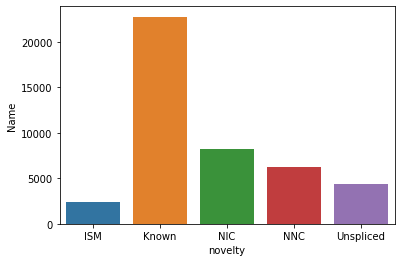

In [17]:
df = ca.ic.loc[ca.ic.source.str.contains('isoquant')].copy(deep=True)
temp = df[['novelty', 'Name']].groupby('novelty').count().reset_index()
sns.barplot(temp, y='Name', x='novelty')

<AxesSubplot:xlabel='novelty', ylabel='Name'>

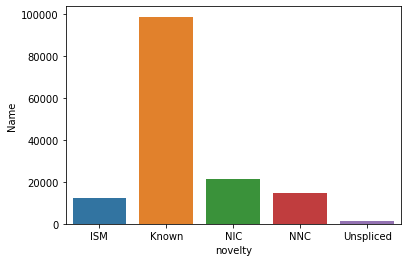

In [18]:
df = ca.ic.loc[ca.ic.source.str.contains('lapa')].copy(deep=True)
temp = df[['novelty', 'Name']].groupby('novelty').count().reset_index()
sns.barplot(temp, y='Name', x='novelty')

## Format IsoQuant abundance file

In [20]:
def format_isoquant_ab(ab, dataset, lib_meta, ofile):
    """
    Format abundance file from isoquant GFF into a format
    that Cerberus can deal with
    """
    meta = pd.read_csv(lib_meta, sep='\t')
    df = pd.read_csv(ab, sep='\t')
    df.head()
    df['annot_transcript_id'] = df['#feature_id']
    df['annot_transcript_name'] = df['annot_transcript_id']
    df['transcript_ID'] = df['annot_transcript_id']
    df.columns = [c.split('.')[0] for c in df.columns]
    df.drop('#feature_id', axis=1, inplace=True)
    m = dict([(entry['ENCODE_alignments_id'], entry['dataset']) for ind, entry in meta[['dataset', 'ENCODE_alignments_id']].iterrows()])
    df.columns = [m[c] if 'ENCFF' in c else c for c in df.columns]
    
    df.to_csv(ofile, sep='\t', index=False)

In [48]:

df.head()


,wtc11_1_1,wtc11_1_3,wtc11_1_2,annot_transcript_id,annot_transcript_name,transcript_ID
0,5.016551,4.130977,10.360410,ENST00000003583.12,ENST00000003583.12,ENST00000003583.12
1,2.315331,1.652391,6.906940,ENST00000003912.7,ENST00000003912.7,ENST00000003912.7
2,27.012200,16.523907,12.662723,ENST00000040877.1,ENST00000040877.1,ENST00000040877.1
3,12.348434,12.117532,18.418507,ENST00000054650.8,ENST00000054650.8,ENST00000054650.8
4,50.165515,40.758970,56.406677,ENST00000054666.10,ENST00000054666.10,ENST00000054666.10


In [34]:
meta = pd.read_csv(lib_meta, sep='\t')
meta.head()

,ENCODE_experiment_id,dataset,sample,sample_display,general_tissue_cell_type,fig1_tissue_label,health_status,tissue_or_cell_line,sample_color_hex_code,matching_mouse_samples,reads_post_talon,ENCODE_alignments_id,ENCODE_reads_id,ENCODE_unfiltered_alignments_id,document_urls,document_labels,platform,RIN,spikeins
0,ENCSR989ZYL,a673_1_1,a673,A673,a673,bone,NaN,cell_line,#de3700,NaN,1330194,ENCFF045ZQI,ENCFF168MIB,ENCFF440LXJ,https://www.encodeproject.org/documents/6d583a...,'ENCODE Long Read RNA-Seq Analysis Protocol fo...,Pacific Biosciences Sequel II,9.8,True
1,ENCSR989ZYL,a673_1_2,a673,A673,a673,bone,NaN,cell_line,#de3700,NaN,1707207,ENCFF320GCF,ENCFF861BKY,ENCFF240FZT,https://www.encodeproject.org/documents/6d583a...,'ENCODE Long Read RNA-Seq Analysis Protocol fo...,Pacific Biosciences Sequel II,9.8,True
2,ENCSR081NRO,adrenal_gland_1_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",765655,ENCFF147OYL,ENCFF211SQY,ENCFF967OHL,https://www.encodeproject.org/documents/54012f...,'non-size selected cDNA libraries for use in P...,Pacific Biosciences Sequel,9.8,False
3,ENCSR563RLX,adrenal_gland_2_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",1579294,ENCFF791WUV,ENCFF417ALN,ENCFF900XHI,https://www.encodeproject.org/documents/3baa46...,"'PacBio libraries v3 (October, 2020) Protocol ...",Pacific Biosciences Sequel II,NaN,True
4,ENCSR995WKW,adrenal_gland_3_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",577077,ENCFF243PFI,ENCFF912HPY,ENCFF020MWV,https://www.encodeproject.org/documents/54012f...,'non-size selected cDNA libraries for use in P...,Pacific Biosciences Sequel,9.4,False
